## Diabetes Prediction using Diagnostic Features Dataset DTA

<h3>Importing Libraries</h3>

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

**Loading the Dataset**

In [5]:
import time
# store starting time
begin_dataprep = time.time()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
torch.cuda.is_available()

True

### Encoding codes used
code used for categories = {'female':1,
            'male':0,
            'Normal':0,
            'Diabetes':1,
            'Prediabetic':2,
           }

In [8]:
#Reading the data and some data are not present as decimals
df=pd.read_csv("NIDDK-DF-new-3targets.csv")
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,193,77,49,3.9,19,0,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,0,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,0,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,0,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,0,70,141,20.2,122,86,32,39,0.82,0


In [9]:
df.dtypes

cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
gender               int64
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
Outcome              int64
dtype: object

In [10]:
df.rename({'Outcome': 'Class'}, axis=1, inplace=True)

In [11]:
df.dtypes

cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
gender               int64
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
Class                int64
dtype: object

In [12]:
# Eliminate duplicates
#Delete original label
#df['gender'] = df['gender'].astype('str')
print('There are' , df.duplicated().sum() , 'duplicates')
df.loc[df.duplicated(keep=False),:]
df.drop_duplicates(keep='first',inplace=True)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')

There are 0 duplicates
There is now 390 rows
There is now 15 columns


In [13]:
df_old=df

In [14]:
'''df = pd.get_dummies(df, columns = ['gender'])
#print(df)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')'''

"df = pd.get_dummies(df, columns = ['gender'])\n#print(df)\nprint('There is now' , df.shape[0] , 'rows')\nprint('There is now' , df.shape[1] , 'columns')"

In [15]:
df.columns

Index(['cholesterol', 'glucose', 'hdl_chol', 'chol_hdl_ratio', 'age', 'gender',
       'height', 'weight', 'bmi', 'systolic_bp', 'diastolic_bp', 'waist',
       'hip', 'waist_hip_ratio', 'Class'],
      dtype='object')

In [16]:
df['Class'].value_counts()

0    279
1     60
2     51
Name: Class, dtype: int64

In [17]:
difference_in_class_occurences = df['Class'].value_counts()[0]-df['Class'].value_counts()[2]
difference_in_class_occurences

228

In [18]:
#Class occurences for all classes
print('Number of normal people', df['Class'].value_counts()[0])
print('Number of diabetic people', df['Class'].value_counts()[1])
print('Number of prediabetic people', df['Class'].value_counts()[2])

Number of normal people 279
Number of diabetic people 60
Number of prediabetic people 51


In [19]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='Class', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_diab = X_train_scaled[np.where(y_train==0)[0]] ##For Prediabetic
X_test_diab = X_test_scaled[np.where(y_test==0)[0]]  ##For Prediabetic

In [20]:
X_train_diab.shape

(192, 14)

In [21]:
X_test_diab.shape

(87, 14)

In [22]:
datasets = dta.create_datasets(X_train_diab, y_train.values[np.where(y_train==0)], X_test_diab, y_test.values[np.where(y_test==0)])
data = dta.DataBunch(*dta.create_loaders(datasets, device='cuda')) # earlier 'cpu'

In [23]:
D_in = X_train_diab.shape[1]
VAE_arch = [50, 12, 12]
target_name = 'Class'
target_class = 0
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [24]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

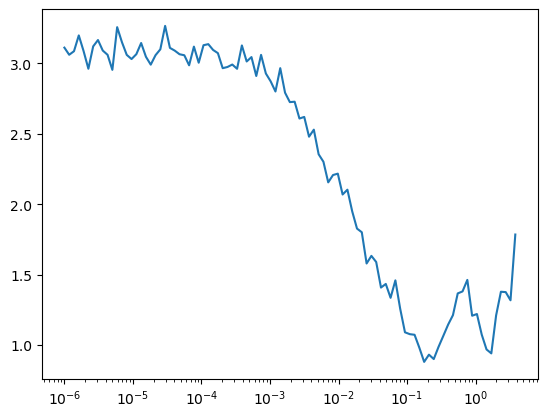

In [25]:
run.recorder.plot(skip_last=5)

In [26]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [27]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 4.283169746398926
validation loss is: 1.2226626873016357
epoch: 100
train loss is: 1.253494381904602
validation loss is: 0.9537752270698547
epoch: 150
train loss is: 1.0640909671783447
validation loss is: 0.9451726078987122
epoch: 200
train loss is: 0.998530924320221
validation loss is: 0.9421562552452087
epoch: 250
train loss is: 0.966469407081604
validation loss is: 0.9407380223274231
epoch: 300
train loss is: 0.9473779797554016
validation loss is: 0.9398635029792786
epoch: 350
train loss is: 0.9343193769454956
validation loss is: 0.9392707347869873
epoch: 400
train loss is: 0.924404501914978
validation loss is: 0.9386141300201416


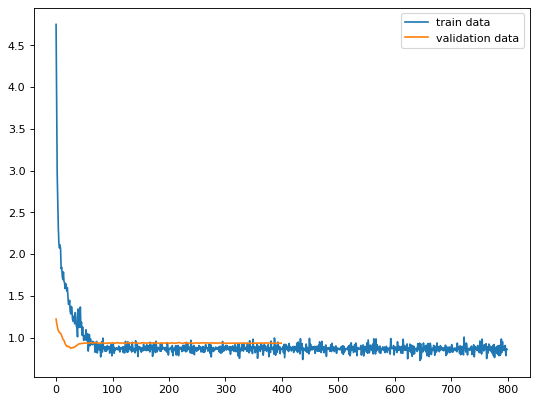

In [28]:
run.loss_tracker.plot_train_vs_val_loss()

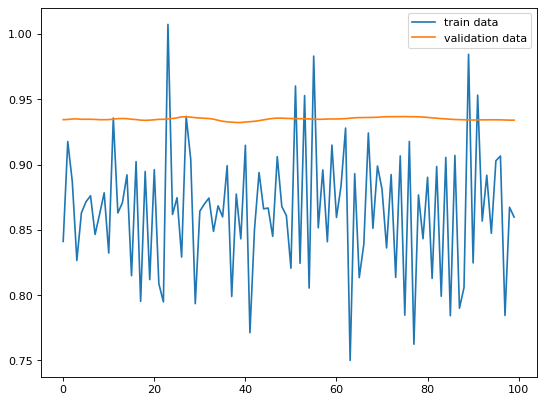

In [29]:
run.loss_tracker.plot_train_vs_val_loss_last_epochs(show_last=100)

In [30]:
df_cols = list(df.columns)
list(df[df['Class']==0][df_cols].std()/10)

[4.128791576653887,
 2.787378355183128,
 1.7115410859181104,
 0.1439520629806995,
 1.5825986537177985,
 0.04931128780120321,
 0.38393952157336825,
 3.9142008124001135,
 0.6316779349367725,
 2.2749098718046676,
 1.3723254425387925,
 0.5591861975012694,
 0.5474480224682063,
 0.00720310788182547,
 0.0]

In [31]:
# difference_in_class_occurences = 1000
df_fake = run.predict_df(learn, no_samples=difference_in_class_occurences, scaler=x_scaler)
std_list = list(df[df['Class']==0][df_cols].std()/10)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_class_occurences, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Class
0,199.692495,83.659173,53.494800,4.460864,43.708050,0.399783,65.524799,174.060137,27.278662,137.003455,83.049474,37.006908,42.388326,0.875887,0
1,203.323548,87.924762,48.956189,4.278413,40.806894,0.436164,65.706929,177.986111,27.623752,130.790364,82.834855,37.820887,42.166886,0.870257,0
2,204.129328,83.616040,52.356787,4.047796,41.236792,0.396343,65.717754,170.953652,28.134840,131.912305,81.075953,37.145673,43.538805,0.877971,0
3,201.323840,96.133443,51.202701,4.162128,43.099514,0.410553,66.197369,174.144716,27.246751,130.594987,82.899084,36.765509,40.754445,0.871119,0
4,198.535751,84.591270,52.433568,4.157186,44.795519,0.386716,66.578926,172.509138,27.347693,129.473524,82.910106,37.282787,42.578646,0.874897,0


In [32]:
df_fake_with_noise.shape

(228, 15)

In [33]:
df_fake_with_noise.describe()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Class
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.0
mean,202.139739,88.307595,51.841980,4.187940,43.675428,0.392179,66.014251,173.916895,28.261814,133.500934,81.945106,37.205448,42.642896,0.871447,0.0
std,3.694839,2.778725,1.824011,0.157364,1.535899,0.049534,0.414156,3.796986,0.655850,2.112199,1.389127,0.498924,0.602654,0.007882,0.0
min,192.493760,80.732579,47.558446,3.652629,38.237550,0.265787,64.872788,159.964248,26.639895,127.460855,77.910948,35.856161,40.754445,0.839947,0.0
25%,199.690443,86.363557,50.641258,4.075550,42.678453,0.358859,65.726088,171.451482,27.777120,131.920827,81.088709,36.897533,42.232748,0.866912,0.0
50%,202.030605,88.231255,51.751281,4.187271,43.657350,0.394387,66.041690,174.059989,28.280219,133.698976,81.770682,37.205393,42.661455,0.871285,0.0
75%,204.586974,89.886424,53.035813,4.280431,44.615122,0.427284,66.294050,176.242233,28.691132,134.794411,82.893263,37.568087,43.085595,0.876831,0.0
max,212.043862,97.028178,56.773454,4.674063,47.798236,0.528945,67.070262,185.539406,30.110210,139.887517,86.689866,38.456996,44.228088,0.894681,0.0


In [34]:
data1=df[df['Class']==0]

In [35]:
data1.describe()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Class
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.0
mean,202.154122,88.308244,51.071685,4.306810,43.824373,0.412186,65.992832,173.982079,28.172760,134.146953,82.304659,37.200717,42.480287,0.876165,0.0
std,41.287916,27.873784,17.115411,1.439521,15.825987,0.493113,3.839395,39.142008,6.316779,22.749099,13.723254,5.591862,5.474480,0.072031,0.0
min,78.000000,48.000000,12.000000,1.900000,19.000000,0.000000,55.000000,99.000000,15.200000,90.000000,48.000000,26.000000,32.000000,0.680000,0.0
25%,174.000000,77.000000,40.000000,3.200000,31.000000,0.000000,63.000000,145.000000,23.400000,120.000000,72.000000,33.000000,39.000000,0.830000,0.0
50%,198.000000,84.000000,47.000000,4.100000,41.000000,0.000000,66.000000,170.000000,27.500000,130.000000,81.000000,37.000000,42.000000,0.870000,0.0
75%,224.500000,91.000000,59.000000,5.250000,54.000000,1.000000,69.000000,195.500000,31.500000,142.000000,90.000000,41.000000,46.000000,0.920000,0.0
max,347.000000,371.000000,120.000000,10.600000,92.000000,1.000000,76.000000,308.000000,50.500000,250.000000,124.000000,52.000000,64.000000,1.140000,0.0


In [36]:
df_fake_with_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      228 non-null    float64
 1   glucose          228 non-null    float64
 2   hdl_chol         228 non-null    float64
 3   chol_hdl_ratio   228 non-null    float64
 4   age              228 non-null    float64
 5   gender           228 non-null    float64
 6   height           228 non-null    float64
 7   weight           228 non-null    float64
 8   bmi              228 non-null    float64
 9   systolic_bp      228 non-null    float64
 10  diastolic_bp     228 non-null    float64
 11  waist            228 non-null    float64
 12  hip              228 non-null    float64
 13  waist_hip_ratio  228 non-null    float64
 14  Class            228 non-null    int64  
dtypes: float64(14), int64(1)
memory usage: 26.8 KB


In [37]:
df_fake_with_noise['gender'] = np.where((df_fake_with_noise['gender']<=0.5),'female','male')

In [38]:
df_fake['gender'] = np.where((df_fake['gender']<=0.5),'female','male')

In [39]:
df_fake['gender'].value_counts()

female    228
Name: gender, dtype: int64

In [40]:
df_fake_with_noise['gender'].value_counts()

female    226
male        2
Name: gender, dtype: int64

In [41]:
df_final = pd.concat([df_old, df_fake_with_noise], ignore_index=True)

In [42]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      618 non-null    float64
 1   glucose          618 non-null    float64
 2   hdl_chol         618 non-null    float64
 3   chol_hdl_ratio   618 non-null    float64
 4   age              618 non-null    float64
 5   gender           618 non-null    object 
 6   height           618 non-null    float64
 7   weight           618 non-null    float64
 8   bmi              618 non-null    float64
 9   systolic_bp      618 non-null    float64
 10  diastolic_bp     618 non-null    float64
 11  waist            618 non-null    float64
 12  hip              618 non-null    float64
 13  waist_hip_ratio  618 non-null    float64
 14  Class            618 non-null    int64  
dtypes: float64(13), int64(1), object(1)
memory usage: 72.5+ KB


In [43]:
#save data
df_final.to_csv('NIDDK-DF_DTA_normal.csv',index=False, header=True)

In [44]:
#save data
df_fake_with_noise.to_csv('NIDDK-DF_DTA_normal_syn_withnoise.csv',index=False, header=True)
df_fake.to_csv('NIDDK-DF_DTA_normal_syn.csv',index=False, header=True)

Details of DTA can be found in:

https://github.com/lschmiddey/deep_tabular_augmentation?tab=MIT-1-ov-file


MIT License

Copyright (c) 2021 lschmiddey

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.